In [2]:
from astropy.io import fits
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import utils

from dataset import SunImageDataset

In [3]:
dl = SunImageDataset(remake=False)

In [16]:
test_images_1 = dl.get_images(pathlib.Path('../datasets/processed/2014-02-12-H19-M45'), ['0304', 'ew'])
test_images_2 = dl.get_images(pathlib.Path('../datasets/processed/2014-06-17-H16-M22'), ['0304', 'ew'])

In [5]:
dl.y_tensor

tensor([[[[ 1.5827e-01,  2.5519e-01,  2.8793e-01,  ...,  3.6752e-01,
            6.2517e-04,  1.4587e-01],
          [ 2.4909e-01,  2.7725e-01,  5.0345e-01,  ...,  8.9266e-02,
            6.7461e-02,  2.6282e-01],
          [ 2.9392e-01,  4.8026e-01,  4.8288e-01,  ...,  8.5044e-01,
            7.3569e-01,  2.8902e-01],
          ...,
          [ 1.0732e-01,  8.0994e-03,  1.0931e-01,  ...,  1.5755e-01,
            4.4018e-01,  1.2796e-01],
          [ 8.7942e-03,  3.3974e-01,  1.8953e-01,  ...,  5.5965e-01,
            5.9870e-02,  2.9914e-01],
          [ 2.6306e-01, -7.1504e-02,  2.4814e-01,  ...,  2.6856e-01,
           -7.3430e-02,  2.4183e-01]]],


        [[[-1.7612e-01,  3.0371e-01,  3.3200e-02,  ..., -1.2398e-01,
           -2.9235e-02,  1.1590e-01],
          [ 3.2982e-01,  2.4902e-01,  2.4339e-01,  ..., -4.4934e-02,
            1.8100e-01,  1.8006e-01],
          [-2.5773e-02,  5.2105e-01, -5.8334e-02,  ...,  2.1227e-01,
            3.6109e-02, -1.1154e-01],
          ...,
   

[100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.          96.18652725
  73.68652725  99.31152725 100.         100.         100.
 100.         100.         100.          78.06152725  59.31152725
  76.81152725  58.06152725  66.18652725 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.          53.06152725  23.06152725 100.
 100.         100.         100.         100.         100.
  86.81152725 100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.          76.81152725  86.18652725 100.
 100.         100.         100.         100.          94.31152725
  63.68652725  18.06152725  14.31152725  30.56152725  53.68652725
  66.81152725  69.93652725 100.         

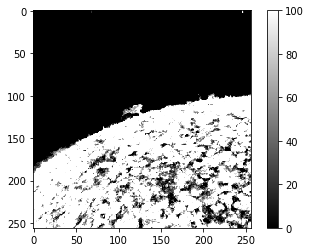

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.8500549e+01  2.9093033e+02
  1.5322542e+02  6.0197903e+01  1.3085716e+01  1.2127295e+00
 -7.1373534e+00  1.5181422e+00  8.7514019e+00  1.2586822e+01
  8.3893623e+00  7.3523366e-01 -1.2060803e+00  7.8178577e+00
  2.1944231e+01  2.8713535e+01  2.8171099e+01  2.6684877e+01
  3.5165150e+01  4.4695084e+01  4.3703537e+01  4.0281593e+01
  4.1105495e+01  4.7111023e+01  5.5294865e+01  5.7579273e+01
  6.4573853e+01  6.8027588e+01  6.9474075e+01  6.7452530e+01
  6.4877319e+01  6.0843330e+01  5.6529572e+01  4.8908100e+01
  3.5090618e+01  3.0689831e+01  2.9860626e+01  2.2215952e+01
  1.6952007e+01  1.23361

<Figure size 432x288 with 0 Axes>

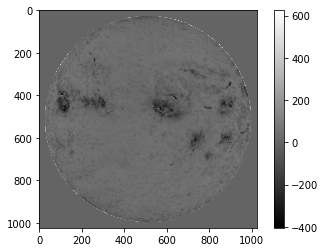

<Figure size 432x288 with 0 Axes>

In [53]:
from skimage.transform import resize

for image in test_images_1:
    colormap = 'gray'
    
    #304
    #left edge = 105 blank pixels
    #Right edge = 106 blank pixels
    #About 105 pixels on all sides
    
    #ew
    #26 pixels on all sides
    if image.image_type == '0304':
        data = image.data[256:512, 0:256] #Left Edge
        #data = image.data[256:512, (1024-256):1024] #Right Edge
        data = image.data[0:256, 256:512] # Top Edge
        mean = np.mean(data)
        data = np.clip(mean + 10 * (data - mean), 0, 100)
        print(data[-1])
    else:
        data = resize(image.data, (1024, 1024))
        print(data[512, 0:256])
    print(data)
    print(data.shape)
    print(image.image_type)
    
    plt.figure()
    plt.imshow(data, cmap=colormap)
    plt.colorbar()
    plt.show()
    plt.clf()

In [21]:
#print(np.array(dl.y_tensor).mean())
to_keep = []
for i in range(len(dl)):
    arr_x = np.array(dl.x_tensor[i]).reshape((512, 512))
    arr_y = np.array(dl.y_tensor[i]).reshape((512, 512))
    #print(f'Mean: {arr.mean()} std: {arr.std()}')
    if not np.isnan(arr_x.mean()) and not np.isnan(arr_y.mean()):
        to_keep.append(i)
    else:
        print(i)

test_x = dl.x_tensor[to_keep, :, :, :]
test_x.size()

238
1061


torch.Size([1319, 1, 512, 512])

In [22]:

#unique_HEI_images = dl.copy_or_download_all_images(start_date="2014-03-01", end_date="2014-03-31")

 [astropy.io.fits.verify]


In [10]:
#df

In [17]:
times = get_unique_times(unique_HEI_images)

In [20]:
ex_time = times[0]
ex_time.strftime('%Y-%m-%d-H%H-M%M')

'2014-03-06-H22-M18'

In [5]:
pd.to_datetime("AIA20100516_1930_1700", format="AIA%Y%m%d_%H%M_1700")

Timestamp('2010-05-16 19:30:00')

In [11]:
#download_SDO_images(times)

In [31]:
dl = ImageDataLoader('SDO')
#dl.path_exists()
test_path = dl.get_path()
test_fits_paths = dl.get_compressed_files()
test_images = dl.get_images()

In [32]:
print(test_images)

[<__main__.Image object at 0x2ab7a7d0f5c0>, <__main__.Image object at 0x2ab78ab53208>, <__main__.Image object at 0x2ab7a833deb8>, <__main__.Image object at 0x2ab7a834d080>, <__main__.Image object at 0x2ab7a79efe48>, <__main__.Image object at 0x2ab7a8327a58>, <__main__.Image object at 0x2ab7a8301f98>, <__main__.Image object at 0x2ab7a833d208>, <__main__.Image object at 0x2ab7a8392438>]


1700


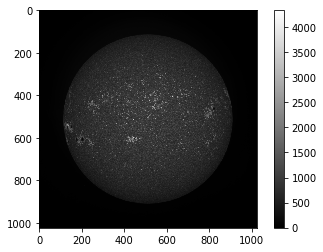

0131


<Figure size 432x288 with 0 Axes>

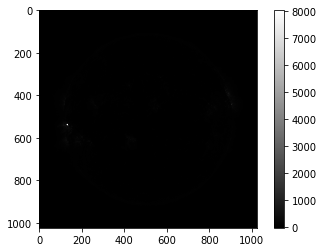

0193


<Figure size 432x288 with 0 Axes>

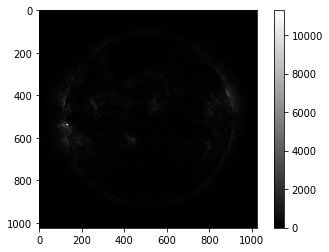

0304


<Figure size 432x288 with 0 Axes>

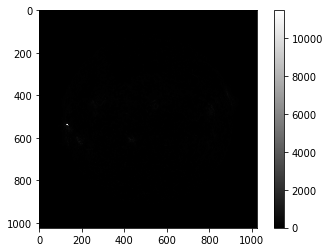

0335


<Figure size 432x288 with 0 Axes>

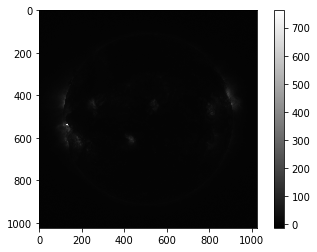

0094


<Figure size 432x288 with 0 Axes>

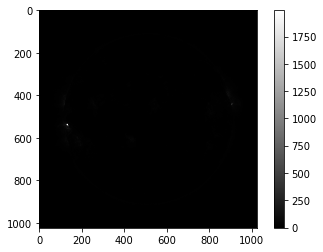

0171


<Figure size 432x288 with 0 Axes>

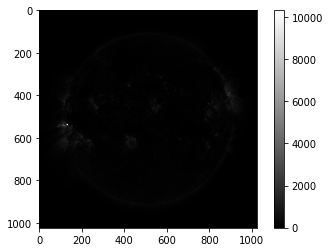

0211


<Figure size 432x288 with 0 Axes>

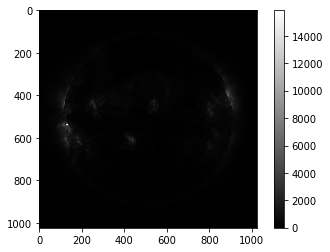

1600


<Figure size 432x288 with 0 Axes>

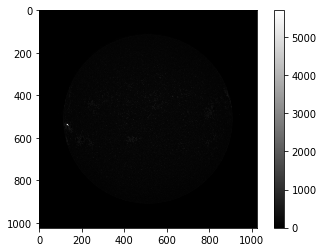

<Figure size 432x288 with 0 Axes>

In [35]:
for image in test_images:
    colormap = 'gray'
    print(image.image_type)
    plt.figure()
    plt.imshow(image.data, cmap=colormap)
    plt.colorbar()
    plt.show()
    plt.clf()

In [36]:
#import gzip
#import shutil

for compressed_fits_file in test_fits_paths:
    print(compressed_fits_file)
    hdulist = fits.open(compressed_fits_file)
    hdulist.info()
    image_data = hdulist[0].data
    image_data = image_data / np.max(image_data)
    colormap = 'gray'
    if len(image_data.shape) == 3:
        image_data = np.transpose(image_data, (1, 2, 0))
        print(image_data[1090])
        print(np.max(image_data))
    plt.figure()
    if len(image_data.shape) == 3:
        plt.imshow(image_data)
    else:
        plt.imshow(image_data, cmap=colormap)
    plt.colorbar()
    plt.show()
    plt.clf()


#compressed_fits_file = test_fits_paths[1]
#print(compressed_fits_file)
#hdulist = fits.open(compressed_fits_file)

../datasets/SDO_Images/data/aia/synoptic/2014/05/07/H0300/AIA20140507_0304_1700.fits
Filename: ../datasets/SDO_Images/data/aia/synoptic/2014/05/07/H0300/AIA20140507_0304_1700.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 CompImageHDU    170   (1024, 1024)   int32   


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [6]:
image_data = hdulist[0].data


In [8]:
print(content)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
[x.suffix for x in test_path.iterdir()]

['', '.jpg', '.jpg', '.gz', '.gz', '.pdf', '.gz']